In [1]:
from sklearn.cluster import KMeans
from itertools import combinations
import pandas as pd
from scipy.spatial import distance
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
import networkx as nx
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.patches as mpatches
from statsmodels.tsa.stattools import acf

In [2]:
filelocation_TET = 'NDT_all_12thDec_uncleaned.csv'   #file location of the Temporal Experience Traces (TET), note needs to be in csv form. With 'feelings' being in columns and individual sessions able to be identified by a unique Subject, Week and Session combination of columns. See this file for the appropriate set up
feelings = ['MetaAwareness','Presence','PhysicalEffort','MentalEffort','Boredom', 'Receptivity', 'EmotionalIntensity', 'Clarity', 'Release', 'Bliss', 'Embodiment', 'Insightfulness', 'Anxiety', 'SpiritualExperience']  #dimensions of the TET to be included in the clustering
feelings_diffs = ['MetaAwareness_diff', 'Presence_diff', 'PhysicalEffort_diff',
       'MentalEffort_diff', 'Boredom_diff', 'Receptivity_diff',
       'EmotionalIntensity_diff', 'Clarity_diff', 'Release_diff', 'Bliss_diff',
       'Embodiment_diff', 'Insightfulness_diff', 'Anxiety_diff',
       'SpiritualExperience_diff'] #to locate the vectorised version of the feelings columns
no_dimensions_PCA = 2 #number of dimensions to run the PCA on
no_clust = 3 #number of vectoral clusters, note the total number of clusters will be one greater as the stable cluster is split into 2
no_of_jumps = 7 #number of timestep jumps in the TET to form the vectors

headers = {'Subject':0, 'Week':1, 'Session':2}
colours = {0:'red',1:'green',2:'blue',3:'orange',4:'pink',5:'yellow'}
colours_list = ['red','green','blue','orange','pink','yellow']
header = 'Week'

In [3]:
# Import necessary libraries
import pandas as pd  

# Class to handle CSV file operations
class csv_splitter:

    def __init__(self, excel_file_name):
        """
        Constructor to initialize the CSV file location.
        :param excel_file_name: Name of the CSV file to be processed.
        """
        self.excel_file_location = f'/Users/a_fin/Desktop/Year 4/Project/Data/{excel_file_name}'  # Define file path
        self.dataframes = None  # Placeholder for storing DataFrame if needed in future methods

    def read_excel(self):
        """
        Reads the CSV file and returns it as a pandas DataFrame.
        :return: DataFrame containing CSV file data.
        """
        try:
            df_excel_file_name = pd.read_csv(self.excel_file_location)  # Load CSV into DataFrame
            return df_excel_file_name  # Return the DataFrame
        except Exception as e:
            print(f"Error reading Excel file: {e}")  # Print error if file reading fails

    def split_by_header(self, df_excel_file_name, heading):
        """
        Splits the DataFrame into multiple DataFrames based on unique values in a specified column.
        :param df_excel_file_name: The DataFrame to be split.
        :param heading: Column name used to split the DataFrame.
        :return: Dictionary of DataFrames and an array containing key-value pairs.
        """
        # Check if the specified heading exists in the DataFrame
        if heading not in df_excel_file_name.columns:
            print(f"Error: '{heading}' not found in DataFrame columns.")  # Print error if column is missing
            return None  # Return None to indicate failure

        # Get unique values from the specified column
        heading_values = df_excel_file_name[heading].unique()

        # Create a dictionary where keys are unique values, and values are corresponding filtered DataFrames
        split_df = {value: df_excel_file_name[df_excel_file_name[heading] == value] for value in heading_values}

        # Convert dictionary into an array format with key-value pairs
        split_df_array = [[key, value] for key, value in split_df.items()]

        return split_df, split_df_array  # Return both dictionary and array of split DataFrames

In [4]:
csv_splitter_instance = csv_splitter(filelocation_TET)
df_csv_file_original = csv_splitter_instance.read_excel()
split_df, split_csv_array = csv_splitter_instance.split_by_header(df_csv_file_original,header)

In [5]:
#finds and plots the principal componants for all of the TET data

class principal_component_finder:

    def __init__(self,csv_file, feelings,no_dimensions):
        self.csv_file_TET = csv_file[feelings]
        corr_matrix = self.csv_file_TET.corr()
        pca = PCA(n_components=no_dimensions)
        self.principal_components=pca.fit_transform(corr_matrix)
        self.explained_variance_ratio = pca.explained_variance_ratio_
    def PCA_TOT(self):
        df_TET_feelings_prin = self.csv_file_TET.dot(self.principal_components)
        for i in range(0,self.principal_components.shape[1]):
            y_values = []
            for j in range(0,len(feelings)):
                y_values.append(self.principal_components[j][i])
            plt.figure()
            plt.bar(feelings,y_values)
            plt.title(f'principal componant {i+1}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            #plt.savefig(f'/Users/a_fin/Desktop/Year 4/Project/Data/{i+1}')
        plt.figure()
        plt.scatter(df_TET_feelings_prin[0],df_TET_feelings_prin[1], s=0.5)
        plt.xlabel('principal componant 1 (bored/effort)')
        plt.ylabel('principal componant 2 (calm)')
        plt.title('Plot of all the data points in PCA space')
        plt.xlim(-6,6)
        plt.ylim(-1,2)
        
        labels = [f'Principal Componant {i+1}' for i in range(self.principal_components.shape[1])]
        plt.figure(figsize=(10, 6))
        plt.bar(labels, self.explained_variance_ratio, color='skyblue')

        # Adding title and labels
        plt.title('Explained Variance Ratio of PCA Components')
        plt.xlabel('Principal Components')
        plt.ylabel('Explained Variance Ratio')
        plt.xticks(rotation=45)  # Rotates labels to prevent overlap
        plt.tight_layout()    
        
        return self.principal_components, self.explained_variance_ratio, df_TET_feelings_prin
    def PCA_split(self,split_df_array):
        split_df_array_TET = [[split_df_array[i][0],split_df_array[i][1][feelings]] for i in range(0,len(split_df_array))]
        split_csv_TET = {split_df_array_TET[i][0]: split_df_array_TET[i][1] for i in range(0,len(split_df_array))}
        df_TET_feelings_prin_dict = {name: split_csv_TET[name].dot(self.principal_components) for name in split_csv_TET.keys()}
        
        for key,value in df_TET_feelings_prin_dict.items():
            plt.figure()
            plt.scatter(value[0],value[1],s=0.5)
            plt.title(key)
            plt.xlabel('principal componant 1 (bored/effort)')
            plt.ylabel('principal componant 2 (calm)')
            plt.xlim(-6,6)
            plt.ylim(-1,2)
            plt.show()
        return df_TET_feelings_prin_dict
    

In [12]:
def K_Means_Vector_Clustering(df_csv_file_original, feelings, feelings_diffs, principal_components):
    split_dict_skip = {}
    for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
        # Skip rows based on no_of_jumps
        group = group.iloc[::no_of_jumps].copy()
        
        # Calculate the diff for each feeling within this group
        for feeling in feelings:
            group[f'{feeling}_diff'] = -group[feeling].diff(-1)
        
        # Store the modified group in the dictionary
        split_dict_skip[(subject, week, session)] = group

    # Concatenate all the groups into a single DataFrame
    df_csv_file = pd.concat([df for df in split_dict_skip.values()])
    split_dict = {}
    for (subject, week, session), group in df_csv_file.groupby(['Subject', 'Week', 'Session']):
        split_dict[(subject, week, session)] = group.copy()
    differences_array = pd.concat([df[:-1] for df in split_dict.values()])
    numbers = []
    for i in range(differences_array.shape[0]):
        numbers.append(i)
    
    differences_array_MI = differences_array.copy()
    differences_array_MI['number'] = numbers
    wcss_best = 10000000
    labels_fin = []
    cluster_centres_fin = []
    for i in range(0,1000):
        kmeans = KMeans(3)
        kmeans.fit(differences_array.iloc[:,-14:])
        labels = kmeans.labels_
        cluster_centres = kmeans.cluster_centers_
        wcss = kmeans.inertia_
        if wcss< wcss_best:
            wcss_best = wcss
            labels_fin = labels
            cluster_centres_fin = cluster_centres
    differences_array_MI['labels unnormalised vectors'] = labels_fin
    point_colours = []
    for i in labels_fin:
        point_colours.append(colours[i])
    differences_array[["principal componant 1", "principal componant 2"]] = differences_array.iloc[:,-14:].dot(principal_components)
    plt.xlabel("principal componant 1 (bored/effort)")
    plt.ylabel("principal componant 2 (calm)")
    plt.title("scatter plot of k means cluster TET data vectors")
    plt.scatter(differences_array["principal componant 1"],differences_array["principal componant 2"],color=point_colours, s=0.5)
    plt.tight_layout()
    #plt.savefig("C:/Users/hugma/diss/data/K_means_vector_scatter_plot")
    plt.show()
    cluster_centres_prin = np.transpose(cluster_centres_fin.dot(principal_components),(1,0))
    for i in range(cluster_centres_prin.shape[1]):
        plt.arrow(0, 0, cluster_centres_prin[0,i], cluster_centres_prin[1,i],
                head_width=0.1, head_length=0.1, fc=colours_list[i], ec=colours_list[i])

    # Set the labels for the axes
    plt.xlabel("principal component 1 (bored*effort)")
    plt.ylabel("principal component 2 (calm)")

    # Create the legend
    legend = ['Cluster {}'.format(i+1) for i in range(cluster_centres_prin.shape[1])]
    plt.legend(legend)
    plt.title("Cluster centres for K-Means Vector")
    plt.xlim(-1.2,1.2)
    plt.ylim(-1.2,1.2)
    plt.tight_layout()
    #plt.savefig("c:/Users/hugma/diss/data/cluster_centres_for_kmeans_vectors")
    for i in range(0,cluster_centres_fin.shape[0]): 
        plt.figure() 
        plt.bar(feelings,cluster_centres_fin[i])
        plt.ylim(-0.22,0.22)
        plt.xticks(rotation=45, ha='right')
        plt.title(f"cluster centroid for cluster {i+1}  ")
        plt.tight_layout()
        #plt.savefig(f'C:/Users/hugma/diss/data/Vector_Cluster_Centroids_{i}')
    magnitudes = []
    for i in range (len(cluster_centres_fin)):
        magnitudes.append(np.linalg.norm(cluster_centres_fin[i]))
    stable_cluster = np.argmin(magnitudes)
    differences_array['clust'] = labels_fin

    df_stable = differences_array[differences_array['clust'] == stable_cluster].copy() 
    wcss_best = float('inf') 
    for i in range(1000):
        kmeans = KMeans(2)
        kmeans.fit(df_stable[feelings])
        labels_test = kmeans.labels_
        cluster_centres = kmeans.cluster_centers_
        wcss = kmeans.inertia_
        if wcss < wcss_best:
            wcss_best = wcss
            labels_fin_stable = labels_test
            cluster_centres_fin_stable = cluster_centres
    df_stable = df_stable.drop('clust', axis=1)
    df_stable['clust_name'] = [f'{stable_cluster+1}a' if label == 0 else f'{stable_cluster+1}b' for label in labels_fin_stable]
    df_stable['clust'] = [stable_cluster if label == 0 else 3 for label in labels_fin_stable]
    differences_array['clust_name'] = differences_array['clust']+1
    differences_array.update(df_stable)

    clust_labels = differences_array['clust'].unique()+1
    clust_name_labels = differences_array['clust_name'].unique()

# Create a dictionary mapping 'clust' labels to 'clust_name' labels
    dictionary_clust_labels = {clust: clust_name for clust, clust_name in zip(clust_labels, clust_name_labels)}
    alphabet = {0:'a', 1:'b'}
    for i in range(0,cluster_centres_fin_stable.shape[0]): 
        plt.figure() 
        plt.bar(feelings,cluster_centres_fin_stable[i])
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0,1)
        plt.title(f"cluster centroid for cluster {stable_cluster+1}{alphabet[i]} k-means on stable points")
        plt.tight_layout()
        #plt.savefig(f'C:/Users/hugma/diss/data/Cluster_Centroids_for_stable_cluster_{i}')
    cluster_centres_prin_stable = np.transpose(cluster_centres_fin_stable.dot(principal_components),(1,0))
    plt.figure()

    for i in range(cluster_centres_prin_stable.shape[1]):
        cluster_label = f'Cluster {stable_cluster + 1}{alphabet[i]}'
        plt.scatter(cluster_centres_prin_stable[0, i], cluster_centres_prin_stable[1, i], label=cluster_label)

    plt.xlabel("Principal Component 1 (Bored*Effort)")
    plt.ylabel("Principal Component 2 (Calm)")
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)
    plt.legend()  # Add the legend to your plot
    plt.tight_layout()
    #plt.savefig('C:/Users/hugma/diss/data/stable_cluster_centroids')
    plt.show()
    num_clusters = cluster_centres_fin_stable.shape[0]
    num_feelings = len(feelings)
    bar_width = 0.8 / num_clusters  # Adjust width for clarity
    offset = np.arange(num_feelings)  # Base offset for each group of bars

    plt.figure(figsize=(10, 8))  # Consider adjusting the size for clarity

    for i in range(num_clusters):
        # Calculate the position for each cluster's bars
        positions = [pos + (bar_width * i) for pos in offset]
        
        cluster_label = f'Cluster {stable_cluster+1}{alphabet[i]}'
        plt.bar(positions, cluster_centres_fin_stable[i], width=bar_width, label=cluster_label)

    plt.xticks(offset + bar_width * num_clusters / 2, feelings, rotation=45, ha='right')  # Adjust tick positions and labels
    plt.ylim(0, 1)
    plt.title("Cluster centroids for k-means on stable points")
    plt.legend()
    plt.tight_layout()
    #plt.savefig('C:/Users/hugma/diss/data/Cluster_Centroids_Bar_plot')
    plt.show()
    differences_array['clust_name'] = differences_array['clust_name'].astype(str)
    (unique, counts) = np.unique(differences_array['clust_name'], return_counts=True)
    label_counts = dict(zip(unique, counts))

    # Convert keys and values to lists for plotting
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    # Creating the bar plot
    plt.figure(figsize=(10, 5))  # Optional: Adjust figure size as needed
    plt.bar(labels, counts)

    # Setting x-axis labels to reflect discrete labels
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation='vertical')  # Rotate labels if there are many or they are long

    # Adding labels and title for clarity
    plt.xlabel('Cluster Labels')
    plt.ylabel('Counts')
    plt.title('Distribution of Cluster Labels')

    # Show the plot
    plt.tight_layout()
    #plt.savefig("C:/Users/hugma/diss/data/Cluster_counts")
    return differences_array, dictionary_clust_labels

In [13]:
def K_Means_Vector_Visualise(differences_array, df_csv_file_original, dictionary_clust_labels, principal_components):
    differences_array[["principal componant 1 non-diff", "principal componant 2 non-diff"]] = differences_array[feelings].dot(principal_components)
    traj_transitions_dict = {}
    traj_transitions_dict_original = {}
    color_map = {
        0: 'red',
        1: 'green',
        2: 'blue',
        3: 'yellow',
    }
    for heading,group in df_csv_file_original.groupby(['Subject','Week','Session']):
        traj_transitions_dict_original[heading] = group
    for heading,group in differences_array.groupby(['Subject','Week','Session']):
        traj_transitions_dict[heading] = group

    for heading,value in traj_transitions_dict_original.items():
        plt.figure()
        for feeling in feelings:
            starting_time = 0 
            time_jump = 28
            time_array = np.arange(starting_time, starting_time + time_jump * value.shape[0], time_jump)
            plt.plot(time_array,value[feeling]*10,label=feeling)
        combined = ''.join(heading)


        cleaned = combined.replace("\\", "").replace("'", "").replace(" ", "").replace("(", "").replace(")", "")
        
        
        plt.title(f'{cleaned}')    
        plt.xlabel('Time')
        plt.ylabel('Rating')
        plt.tight_layout() 
        

        
        
        prev_color_val = traj_transitions_dict[heading]['clust'].iloc[0]
        start_index = 0
        for index, color_val in enumerate(traj_transitions_dict[heading]['clust']):
            if color_val != prev_color_val or index == traj_transitions_dict[heading].shape[0] - 1:
                # Only go up to the previous index if it's not the last span
                end_index = index*(time_jump*no_of_jumps) if index != traj_transitions_dict[heading].shape[0] - 1 else time_array[-1]
                plt.axvspan(start_index*(time_jump*no_of_jumps), end_index, facecolor=color_map[prev_color_val], alpha=0.3)
                start_index = index
                prev_color_val = color_val
        cluster_patches = [mpatches.Patch(color=color, label=f'Cluster {cluster}') for cluster, color in color_map.items()]
        
        cluster_patches = [mpatches.Patch(color=color, label=f'Cluster {cluster}') for cluster, color in color_map.items()]
        
        # Combine feelings and cluster legends into one
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.extend(cluster_patches)
        labels.extend([f'Cluster {cluster}' for cluster in dictionary_clust_labels.values()])
        
        plt.legend(handles=handles, labels=labels, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


        #plt.savefig(f"C:/Users/hugma/diss/data/TET_PLOT_final{cleaned}")

In [14]:
def determine_no_jumps_stability(df_csv_file_original, feelings):
    y_labels=[]
    x_labels=[]
    for j in range(1,30):
        split_dict_skip = {}
        for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
                # Skip rows based on `j`
            group = group.iloc[::j].copy()

            # Calculate differences for each feeling before storing in the dictionary
            for feeling in feelings:
                group[f'{feeling}_diff'] = -group[feeling].diff(-1)

            split_dict_skip[(subject, week, session)] = group

        # Concatenate all groups into a single DataFrame
        df_csv_file_new = pd.concat([df for df in split_dict_skip.values()])
        split_dict = {}
        for (subject, week, session), group in df_csv_file_new.groupby(['Subject', 'Week', 'Session']):
            split_dict[(subject, week, session)] = group.copy()
            differences_array = pd.concat([df[:-1] for df in split_dict.values()])
        numbers = []
        for i in range(differences_array.shape[0]):
            numbers.append(i)
        
        differences_array_MI = differences_array.copy()
        differences_array_MI['number'] = numbers
        wcss_best = 10000000
        labels_fin = []
        cluster_centres_fin = []
        for i in range(0,1000):
            kmeans = KMeans(3)
            kmeans.fit(differences_array.iloc[:,-14:])
            labels = kmeans.labels_
            cluster_centres = kmeans.cluster_centers_
            wcss = kmeans.inertia_
            if wcss< wcss_best:
                wcss_best = wcss
                labels_fin = labels
                cluster_centres_fin = cluster_centres
        differences_array_MI['labels unnormalised vectors'] = labels_fin
        (unique, counts) = np.unique(labels, return_counts=True)
        magnitudes = []
        for i in range (len(cluster_centres)):
            magnitudes.append(np.linalg.norm(cluster_centres[i]))
        
        # The function np.unique returns two arrays: one with the unique values and one with their counts
        label_counts = dict(zip(unique, counts))
        print(f'for {j} time steps our cluster distribution is {label_counts}')
        max_clust = [key for key,value in label_counts.items() if value==max(counts)]
        if magnitudes[max_clust[0]]==min(magnitudes):
            print("true")
        else:
            print('false')
        y_labels.append(max(counts)/(sum(counts)-max(counts)))
        x_labels.append(j)
    plt.plot(x_labels,y_labels)
    plt.title('Stable Cluster Dominance with No. of Time Steps')
    plt.xlabel('Number of Time Jumps')
    plt.ylabel('No in stable cluster:No in all other clusters')
    plt.savefig("C:/Users/hugma/diss/data/stable_cluster_dominance")

In [15]:
def determine_no_jumps_consistency(df_csv_file_original, feelings, feelings_diffs):
    x_values=[]
    y_values = []
    for no_of_jumps in range(1,30):
        split_dict_skip = {}
        for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
                # Skip rows based on `j`
            group = group.iloc[::no_of_jumps].copy()

            # Calculate differences for each feeling before storing in the dictionary
            for feeling in feelings:
                group[f'{feeling}_diff'] = -group[feeling].diff(-1)

            split_dict_skip[(subject, week, session)] = group

        # Concatenate all groups into a single DataFrame
        df_csv_file_new = pd.concat([df for df in split_dict_skip.values()])
        split_dict = {}
        for (subject, week, session), group in df_csv_file_new.groupby(['Subject', 'Week', 'Session']):
            split_dict[(subject, week, session)] = group.copy()
            differences_array = pd.concat([df[:-1] for df in split_dict.values()])
        numbers = []
        for i in range(differences_array.shape[0]):
            numbers.append(i)

        differences_array_MI = differences_array.copy()
        differences_array_MI['number'] = numbers
        wcss_best = 10000000
        labels_fin = []
        cluster_centres_fin = []
        for i in range(0,1000):
            kmeans = KMeans(3)
            kmeans.fit(differences_array.iloc[:,-14:])
            labels = kmeans.labels_
            cluster_centres = kmeans.cluster_centers_
            wcss = kmeans.inertia_
            if wcss< wcss_best:
                wcss_best = wcss
                labels_fin = labels
                cluster_centres_fin = cluster_centres
        differences_array_MI['labels unnormalised vectors'] = labels_fin
        downsampled_groups = []
        for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
            downsampled = group.iloc[::no_of_jumps].copy()
            downsampled = downsampled[:-1]
            downsampled['Original_Index'] = downsampled.index
            downsampled_groups.append(downsampled)

        # Concatenate downsampled groups into a DataFrame
        df_downsampled = pd.concat(downsampled_groups)
        df_downsampled['Cluster_Label'] = labels_fin
        df_csv_file_original['Cluster_Label'] = np.nan
        for _, row in df_downsampled.iterrows():
            original_index = row['Original_Index']
            label = row['Cluster_Label']
            # Find the group of the original index
            group_info = df_csv_file_original.loc[original_index, ['Subject', 'Week', 'Session']]
            group_mask = (df_csv_file_original['Subject'] == group_info['Subject']) & \
                        (df_csv_file_original['Week'] == group_info['Week']) & \
                        (df_csv_file_original['Session'] == group_info['Session'])
            group_indices = df_csv_file_original[group_mask].index
            # Find the position of the original index within its group
            pos_in_group = list(group_indices).index(original_index)
            # Calculate the start and end indices to assign labels within the group based on no_of_jumps
            start_idx = pos_in_group - (pos_in_group % no_of_jumps)
            end_idx = min(start_idx + no_of_jumps, len(group_indices))
            for i in range(start_idx, end_idx):
                df_csv_file_original.at[group_indices[i], 'Cluster_Label'] = label
        for feeling in feelings: 


                df_csv_file_original[f'{feeling}_diff'] = -df_csv_file_original[feeling].diff(-1)
        n_entries = 0  # This will count entries considered in the calculation
        correct_assignments = 0

        for i, row in df_csv_file_original.iterrows():
            if not pd.isnull(row['Cluster_Label']) and not row[feelings_diffs].isnull().any():
                # Both cluster label and feelings_diffs are not NaN
                entry = row[feelings_diffs]*no_of_jumps # Extract features
                assigned_cluster = row['Cluster_Label']
                
                # Calculate distances to all cluster centers
                distances = np.array([distance.euclidean(entry, centre) for centre in cluster_centres_fin])
                
                # Find the index of the closest cluster center
                closest_centre_idx = np.argmin(distances)
                
                # Check if the assigned cluster is the closest
                if closest_centre_idx == assigned_cluster:
                    correct_assignments += 1
                
                n_entries += 1  # Increment count of entries considered

        if n_entries > 0:
            hughes_measure = correct_assignments / n_entries
        y_values.append(hughes_measure)
        x_values.append(no_of_jumps)
    plt.plot(x_values,y_values)
    plt.title('Cluster Vectoral Consistency')
    plt.xlabel('Number of Time Steps')
    plt.ylabel('Correct Assignment Ratio')
    plt.savefig("C:/Users/hugma/diss/data/Cluster_Vectoral_consistency")

In [16]:
def determine_no_of_jumps_autocorrelation(df_csv_file_original, feelings):
    split_dict = {}
    for (subject, week, session), group in df_csv_file_original.groupby(['Subject', 'Week', 'Session']):
        split_dict[(subject, week, session)] = group[feelings].copy()
    acf_results = {feeling: [] for feeling in feelings}

    # Number of lags for ACF calculation
    n_lags = 30

    # Calculate ACF for each feeling in each DataFrame
    for key, df in split_dict.items():
        for feeling in feelings:
            acf_value = acf(df[feeling], nlags=n_lags, fft=True)
            acf_results[feeling].append(acf_value)

    # Average the ACFs across all entries for each feeling
    acf_averages = {feeling: np.mean(np.vstack(acf_results[feeling]), axis=0) for feeling in feelings}
    plt.figure(figsize=(12, 8))
    for feeling, acf_vals in acf_averages.items():
        plt.plot(acf_vals, label=feeling)

    plt.title('Average Autocorrelation Function for Each Feeling')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.legend(title='Feeling', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout() 
    plt.savefig("C:/Users/hugma/diss/data/Autocorrelation for each feeling")

In [ ]:
determine_no_of_jumps_autocorrelation(df_csv_file_original, feelings)

In [ ]:
determine_no_jumps_stability(df_csv_file_original,feelings) #this plots the ratio of the size of the stable cluster compared to all of the rest combined for various time jumps

In [ ]:
determine_no_jumps_consistency(df_csv_file_original, feelings, feelings_diffs) #this provides a score describing the agreement of the cluster assigment for each data point when consider with no time jumps and for varying time jumps

In [20]:
df = split_df
print(split_df)


{'week_1':       Subject    Week Session Condition  MetaAwareness  Presence  \
0        s01\  week_1  run_01     Intro       0.079752  0.157927   
1        s01\  week_1  run_01     Intro       0.090521  0.154184   
2        s01\  week_1  run_01    Breath       0.103346  0.170191   
3        s01\  week_1  run_01    Breath       0.113467  0.184691   
4        s01\  week_1  run_01    Breath       0.122709  0.201506   
...       ...     ...     ...       ...            ...       ...   
22447    s21\  week_1  run_07       END       0.451822  0.588879   
22448    s21\  week_1  run_07       END       0.426416  0.608608   
22449    s21\  week_1  run_07       END       0.416661  0.618160   
22450    s21\  week_1  run_07       END       0.418771  0.638201   
22451    s21\  week_1  run_07       END       0.415164  0.648591   

       PhysicalEffort  MentalEffort   Boredom  Receptivity  ...     delta  \
0            0.986157      0.864791  0.358931     0.325571  ...       NaN   
1            0.988

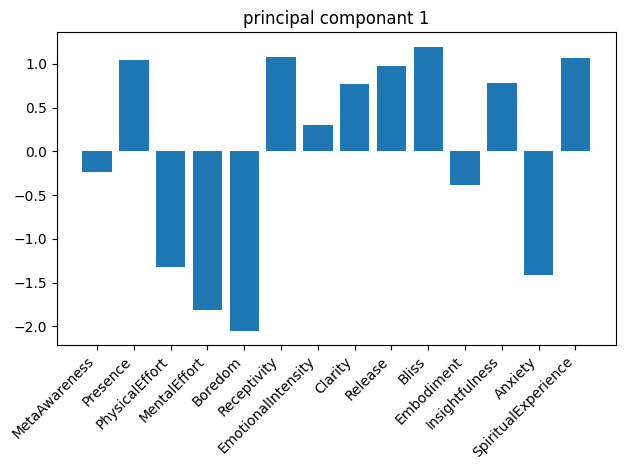

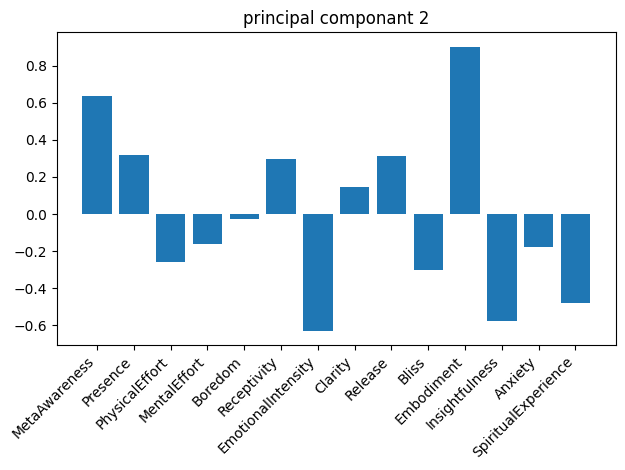

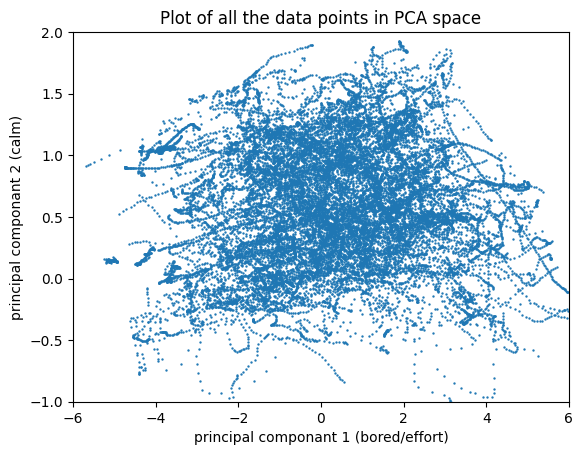

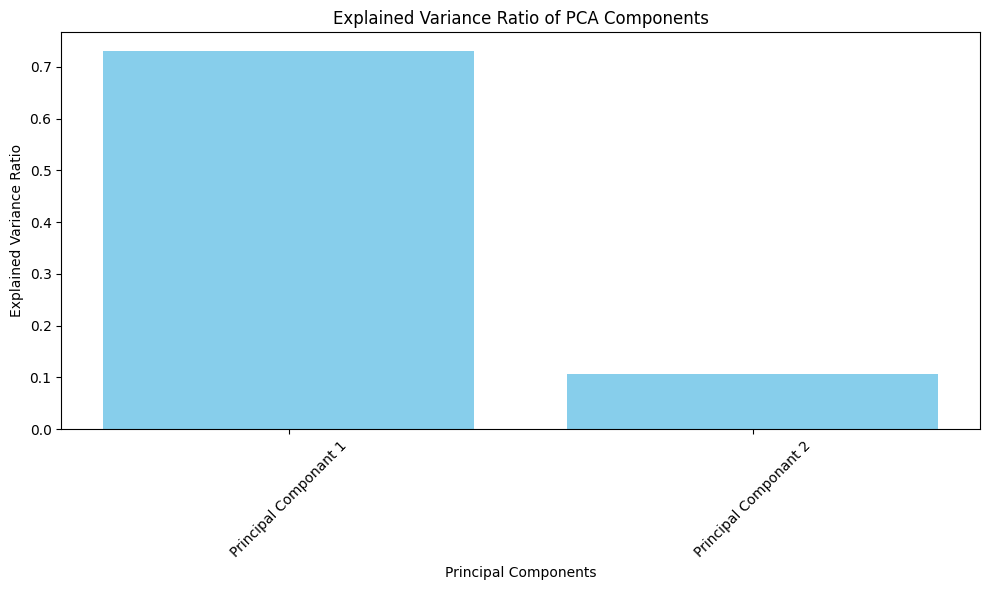

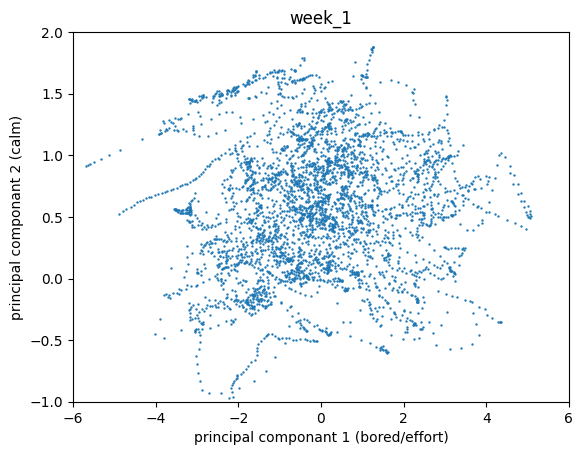

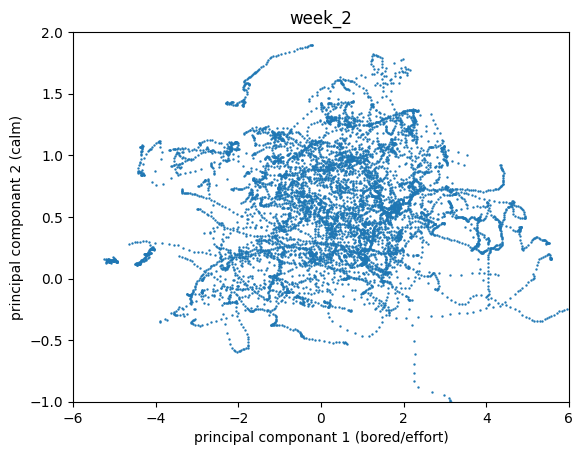

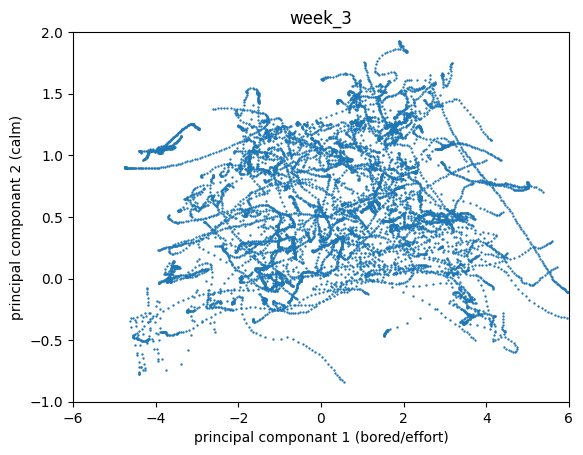

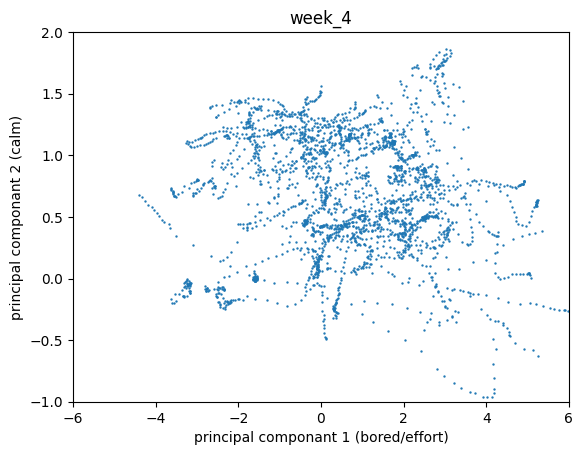

In [17]:
#calling the functions to perform PCA
csv_splitter_instance = csv_splitter(filelocation_TET)
df_csv_file_original = csv_splitter_instance.read_excel()
split_df, split_csv_array = csv_splitter_instance.split_by_header(df_csv_file_original,header)
principal_component_finder_instance = principal_component_finder(df_csv_file_original,feelings,no_dimensions_PCA)
principal_components, explained_variance_ratio, df_TET_feelings_prin = principal_component_finder_instance.PCA_TOT()
df_TET_feelings_prin_dict = principal_component_finder_instance.PCA_split(split_csv_array)

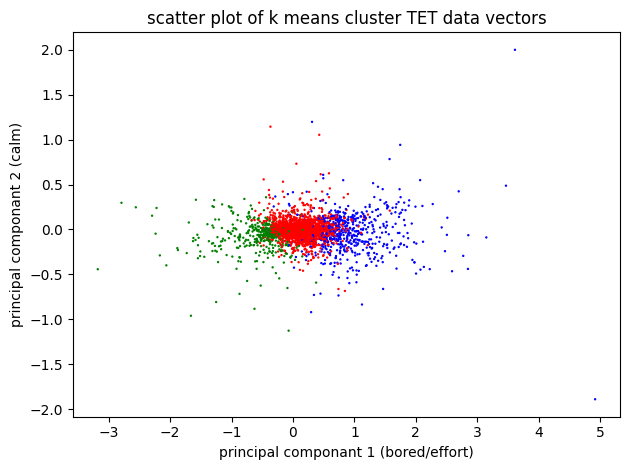

/var/folders/58/lhw9_75n1dj2x_7t6jwvf_v80000gn/T/ipykernel_33861/495404933.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3 2 2 ... 3 1 1]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  differences_array.update(df_stable)
/var/folders/58/lhw9_75n1dj2x_7t6jwvf_v80000gn/T/ipykernel_33861/495404933.py:98: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1b' 3 3 ... '1b' 2 2]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  differences_array.update(df_stable)


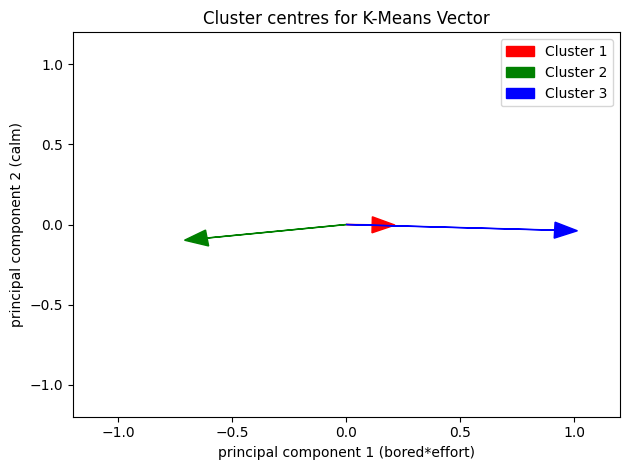

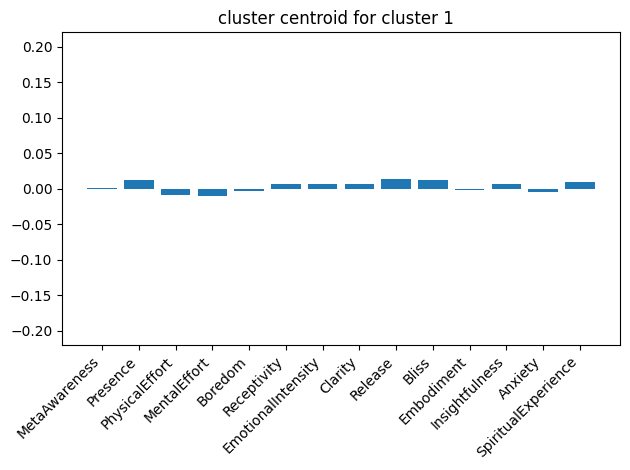

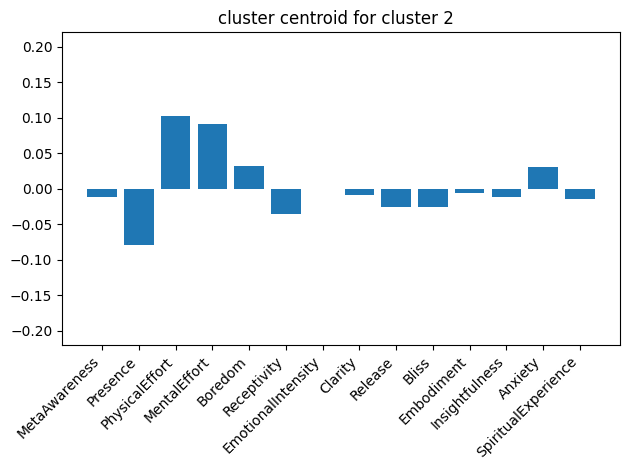

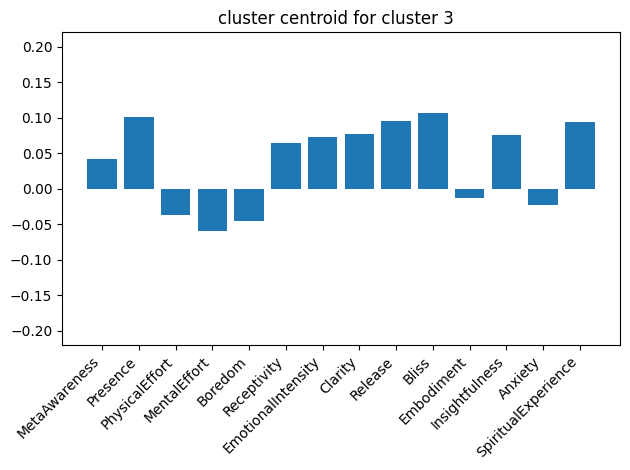

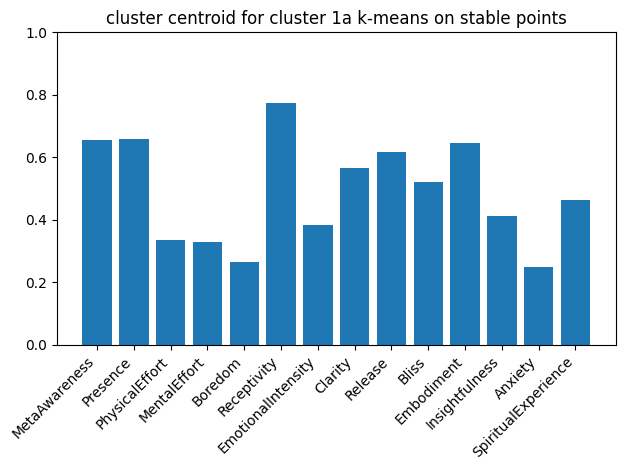

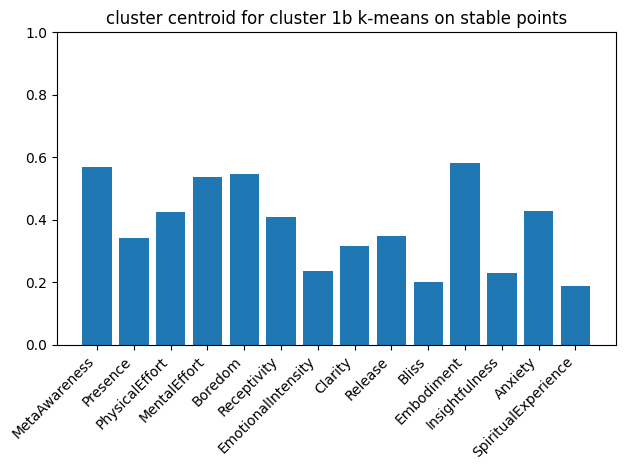

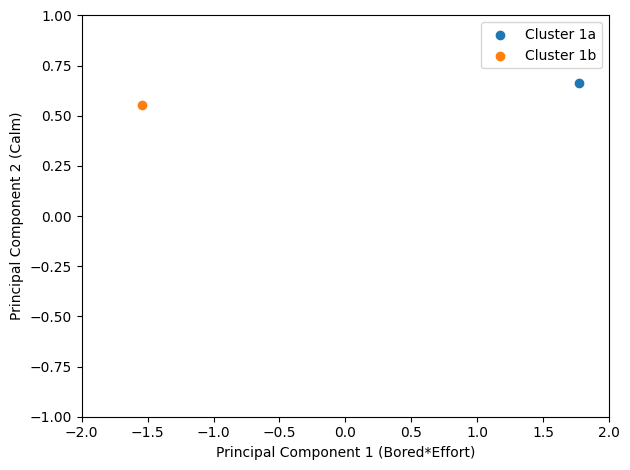

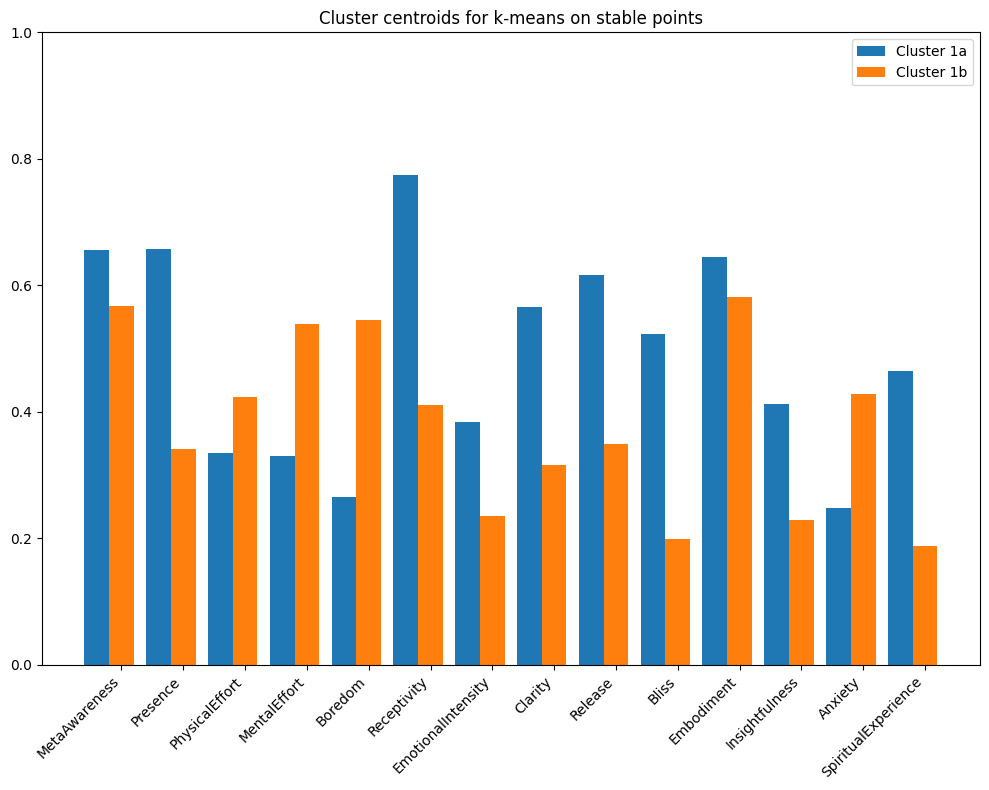

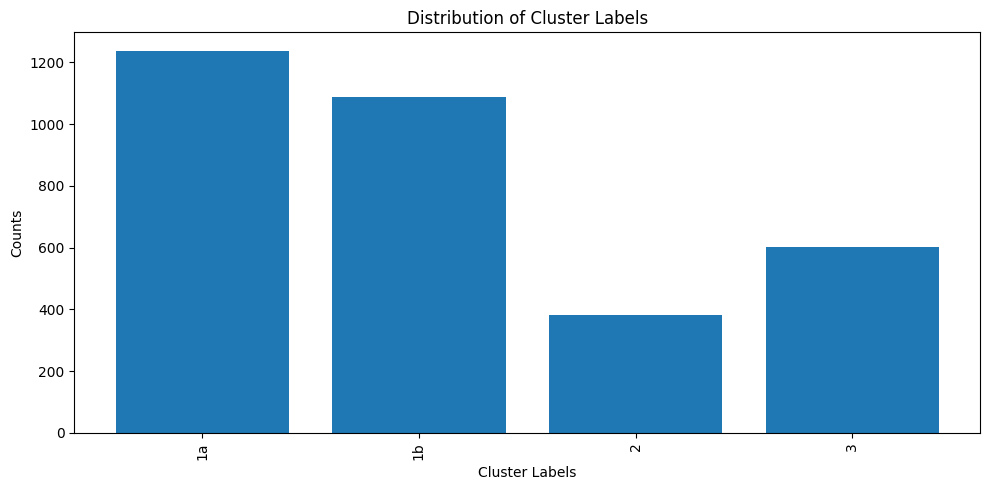

In [37]:
differences_array, dictionary_clust_labels = K_Means_Vector_Clustering(df_csv_file_original, feelings, feelings_diffs, principal_components)

In [ ]:
K_Means_Vector_Visualise(differences_array, df_csv_file_original, dictionary_clust_labels,principal_components)